In [1]:
import numpy as np
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.simulator import (
    SimulationConfig,
    PanelSimulator,
    FactorDGP,
)
from synthlearners.plotting import SynthPlotter

## Basic use with Panel Matrices

In [2]:
config = SimulationConfig(
    N=100,
    T=50,
    T_pre=40,
    n_treated=10,
    selection_mean=1.0,
    treatment_effect=0.5,
    dgp=FactorDGP(K=2, sigma=1, time_fac_lb=-0.1, time_fac_ub=0.1, trend_sigma=0.0001),
)
simulator = PanelSimulator(config)
Y, Y_0, L, treated_units = simulator.simulate()

In [3]:
treated_units

array([89, 32, 13, 80, 85, 28, 82, 45,  9, 64])

In [4]:
from synthlearners.mcnnm import MatrixCompletionEstimator

In [5]:
# Create a mask indicating which entries are observed.
mask = np.ones_like(Y)
missing_periods = config.T-config.T_pre

# For treated units, suppose the outcomes in the last N periods are missing.
mask[treated_units, -missing_periods:] = 0

In [6]:
print(mask.size)
print(np.sum(mask))
print(np.sum(mask)/mask.size)

5000
4900.0
0.98


In [7]:
mask[treated_units[0]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
estimator = MatrixCompletionEstimator(
    max_iter=500,
    tol=1e-6,
    verbose=True
)
estimator.fit(Y, mask)
Y_completed = estimator.completed_matrix_

Max lambda: 0.007533186137141103
CV ratio in observation: 0.98
Trying lambda: 0.0
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 5.23917336066893e-30
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 5.502110696699377e-30
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 1.0497015427072382e-29
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 4.894680802180233e-30
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 3.937915341273604e-30
Trying lambda: 1e-05
shrink_treshhold: 0.0245
Terminated at iteration: 396, for lambda_L: 1e-05, with obj_val: 0.004686217862327942
shrink_treshhold: 0.0245
Terminated at iteration: 415, for lambda_L: 1e-05, with obj_val: 0.004684787654887554
shrink_treshhold: 0.0245
Terminated at iteration: 416, for lambda_L: 1e-05, with obj_val: 0.004678823840165398
shrink_treshhold: 0.0245
Terminated at 

In [9]:
# Counterfactual Values for imputed periods for single treated example
Y_0[treated_units[0], -missing_periods:]

array([-0.76488391, -0.15174888, -0.13119737,  0.30966483,  0.12721515,
        0.81209996,  0.97510635, -1.01615275,  0.85462799, -1.3490142 ])

In [10]:
# Observed Value for imputed periods from single treated example
Y[treated_units[0], -missing_periods:]

array([-0.26488391,  0.34825112,  0.36880263,  0.80966483,  0.62721515,
        1.31209996,  1.47510635, -0.51615275,  1.35462799, -0.8490142 ])

In [11]:
# MC Values for imputed periods for single treated example
Y_completed[treated_units[0], -missing_periods:]

array([-2.00888383e-17, -1.04860412e-16, -1.41254481e-16,  1.13651972e-16,
        2.16201726e-17, -3.57168454e-17,  3.26427319e-17, -6.24121221e-18,
        5.46060435e-17, -1.78606484e-16])

In [12]:
baseline_bias = (
    Y_completed[treated_units[0], -missing_periods:]
    - Y_0[treated_units[0], -missing_periods:]
)
print(
    "Baseline Bias of MC value relative to actual counterfactual",
    np.mean(baseline_bias),
)

Baseline Bias of MC value relative to actual counterfactual 0.033428284120307496


In [13]:
te = (
    Y[treated_units[0], -missing_periods:]
    - Y_completed[treated_units[0], -missing_periods:]
)
print("Estimated Treatment Effect of Observed relative to MC Value", np.mean(te))

Estimated Treatment Effect of Observed relative to MC Value 0.4665717158796926


In [14]:
print("Treatment Effect Bias", np.abs(np.mean(te) - config.treatment_effect))

Treatment Effect Bias 0.033428284120307405


In [15]:
estimator2 = MatrixCompletionEstimator(max_iter=500, tol=1e-10, verbose=True)
# Try approach with fixed effects
estimator2.fit(Y, mask, unit_intercept=True, time_intercept=True)
Y_completed2 = estimator2.completed_matrix_

Max lambda: 0.007299648031903805
CV ratio in observation: 0.98
Trying lambda: 0.0
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 6.627474892420797e-30
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 4.623496401976782e-30
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 4.1875432389217964e-30
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 4.357376137440475e-30
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 4.1312638378352806e-30
Trying lambda: 1e-05
shrink_treshhold: 0.0245
Terminated at iteration: 499, for lambda_L: 1e-05, with obj_val: 0.004554547069053241
shrink_treshhold: 0.0245
Terminated at iteration: 499, for lambda_L: 1e-05, with obj_val: 0.004555530661614948
shrink_treshhold: 0.0245
Terminated at iteration: 499, for lambda_L: 1e-05, with obj_val: 0.004546222984738759
shrink_treshhold: 0.0245
Terminated a

In [16]:
# MC Values for imputed periods for single treated example
Y_completed2[treated_units[0], -missing_periods:]

array([-0.52611637, -0.1970256 , -0.18395093, -0.46182075, -0.49687602,
       -0.07055847, -0.20792772, -0.23242434, -0.16218514, -0.2237233 ])

In [17]:
baseline_bias2 = (
    Y_completed2[treated_units[0], -missing_periods:]
    - Y_0[treated_units[0], -missing_periods:]
)
print(
    "Baseline Bias of MC value relative to actual counterfactual",
    np.mean(baseline_bias2),
)

Baseline Bias of MC value relative to actual counterfactual -0.24283257929370175


In [18]:
te2 = (
    Y[treated_units[0], -missing_periods:]
    - Y_completed2[treated_units[0], -missing_periods:]
)
print("Estimated Treatment Effect of Observed relative to MC Value", np.mean(te2))

Estimated Treatment Effect of Observed relative to MC Value 0.7428325792937016


In [19]:
print("Treatment Effect Bias", np.abs(np.mean(te2) - config.treatment_effect))

Treatment Effect Bias 0.2428325792937016


## Use with workhorse `Synth` class

### Simulation with multiple Treatment Units

In [20]:
config = SimulationConfig(
    N=100,
    T=50,
    T_pre=40,
    n_treated=10,
    selection_mean=1.0,
    treatment_effect=0.5,
    dgp=FactorDGP(K=2, sigma=1, time_fac_lb=-0.1, time_fac_ub=0.1, trend_sigma=0.0001),
)
simulator = PanelSimulator(config)
Y, Y_0, L, treated_units = simulator.simulate()

Computing jackknife estimates:   0%|          | 0/100 [00:00<?, ?it/s]

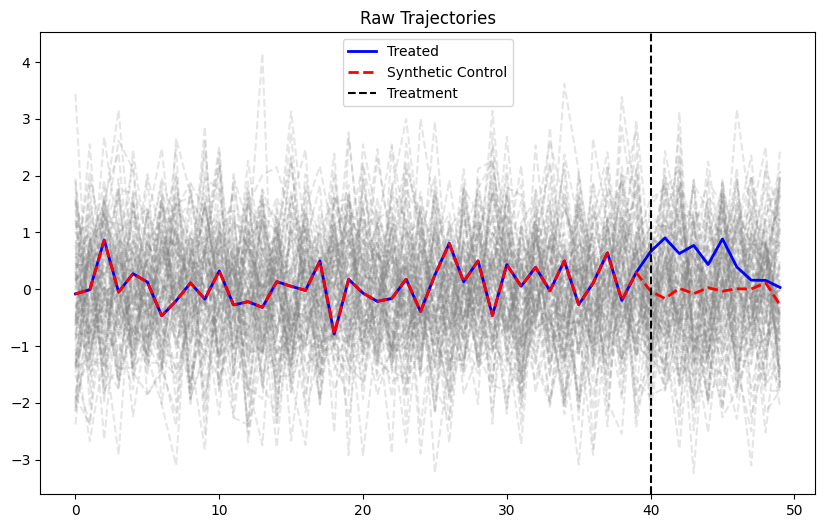

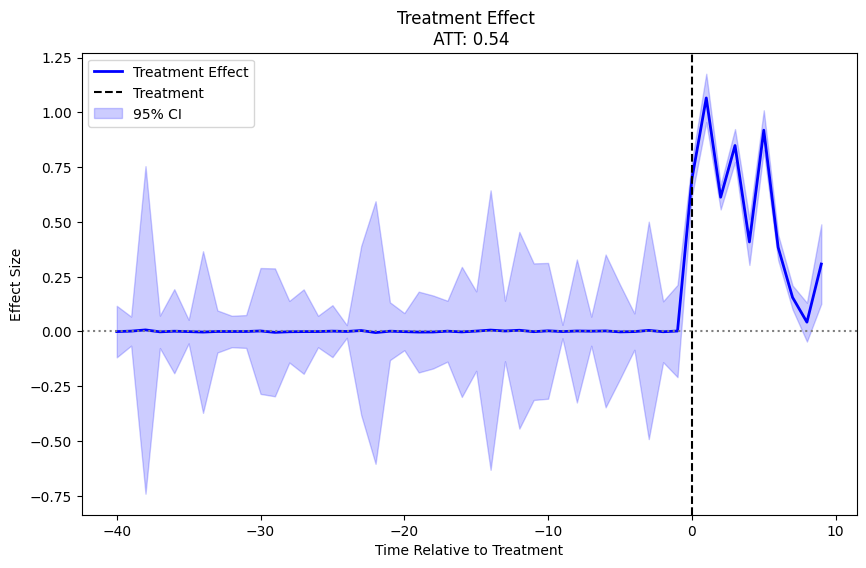

In [21]:
synth = Synth(
    method="matrix_completion",
    n_jobs=-1,
)
results = synth.fit(
    Y,
    treated_units,
    config.T_pre,
    compute_jackknife=True,
)
# Plot raw data
synth.plot(results, Y, treated_units, config.T_pre, mode="raw")
plt.show()
synth.plot(results, Y, treated_units, config.T_pre, mode="effect", show_ci=True)
plt.show()

### ADH Application

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from synthlearners import Synth
from synthlearners.utils import prepare_panel

In [23]:
adh_data = pd.read_csv("ADH2015.csv", index_col=0)
adh_data = adh_data[["country", "year", "gdp"]]
# manually create treatment indicator
adh_data["treat"] = np.where(
    (adh_data.country == "West Germany") & (adh_data.year > 1990), 1, 0
)
adh_data.head()

,country,year,gdp,treat
index,,,,
1.0,USA,1960.0,2879,0
1.0,USA,1961.0,2929,0
1.0,USA,1962.0,3103,0
1.0,USA,1963.0,3227,0
1.0,USA,1964.0,3420,0


In [24]:
data = prepare_panel(
    adh_data,
    unit_col="country",
    time_col="year",
    outcome_col="gdp",
    treatment_col="treat",
)

In [25]:
print(data["W"].size)
print(np.sum(data["W"]))
print(1.0-np.sum(data["W"])/data["W"].size)

748
13
0.982620320855615


Text(0.5, 1.0, 'Treatment matrix')

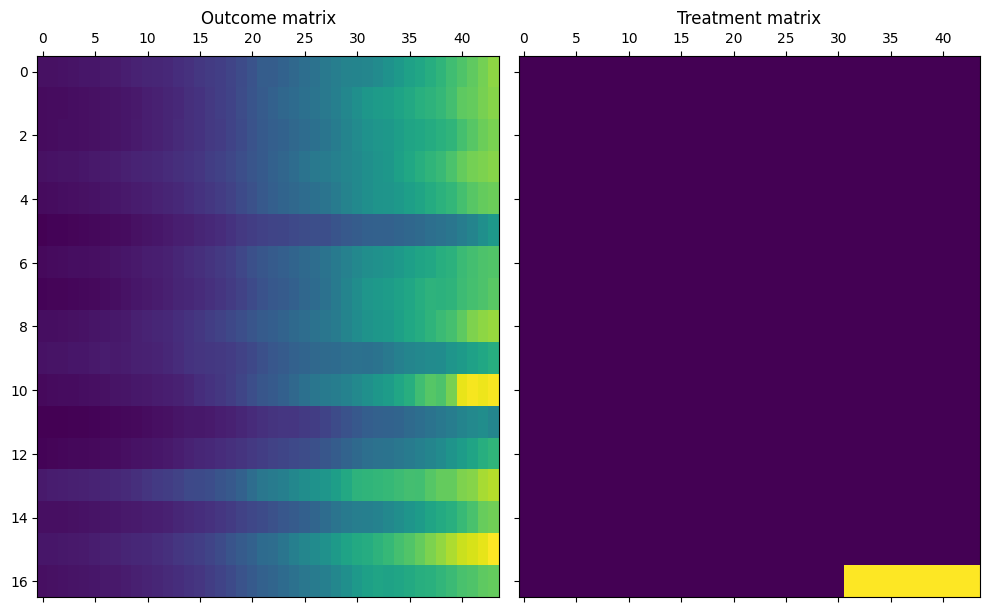

In [26]:
f, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
ax[0].matshow(data["Y"], aspect="auto", cmap="viridis")
ax[1].matshow(data["W"], aspect="auto", cmap="viridis")
f.tight_layout()
ax[0].set_title("Outcome matrix")
ax[1].set_title("Treatment matrix")

In [27]:
# Fit synthetic control - basic
synth = Synth(method="simplex")
results = synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
)

You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

In [28]:
# Fit synthetic control
mc_synth = Synth(method="matrix_completion")
mc_results = mc_synth.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
    verbose=False
)

You have 17 units, so the lowest possible p-value is 0.0625, which is smaller than traditional α of 0.05 
Permutation test may be unreliable


Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

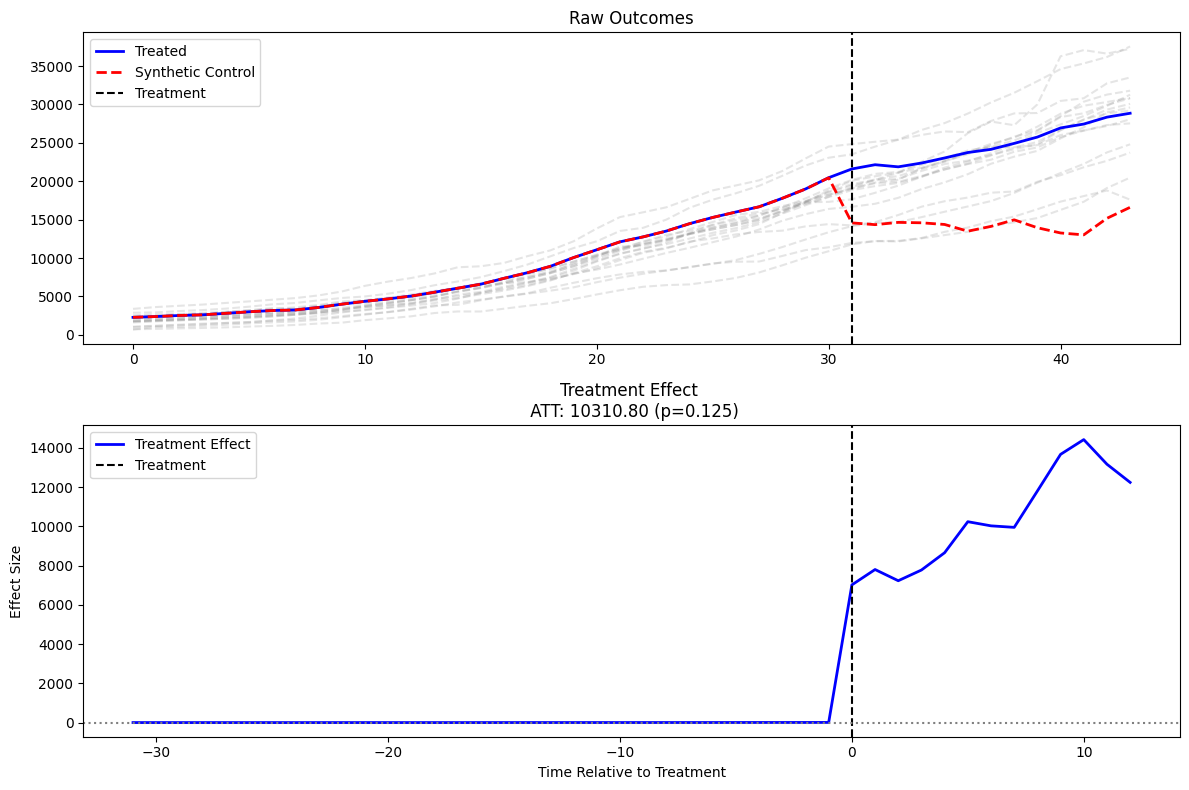

In [29]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
mc_synth.plot(mc_results, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
mc_synth.plot(
    mc_results,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

In [30]:
# Fit synthetic control
mc_synth2 = Synth(method="matrix_completion", unit_intercept=True, time_intercept=True)
mc_results2 = mc_synth2.fit(
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    compute_jackknife=False,
    compute_permutation=True,
    verbose=True,
)

Max lambda: 114.67839133399059
CV ratio in observation: 0.982620320855615
Trying lambda: 0.0
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 1.2346936735128252e-23
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 9.184405797257147e-23
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 7.727780128104244e-23
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 8.50251636440561e-24
shrink_treshhold: 0.0
Terminated at iteration: 0, for lambda_L: 0.0, with obj_val: 9.014580553128913e-23
Trying lambda: 1e-05
shrink_treshhold: 0.0036750000000000003
Terminated at iteration: 9999, for lambda_L: 1e-05, with obj_val: 0.8539990986576697
shrink_treshhold: 0.0036750000000000003
Terminated at iteration: 9999, for lambda_L: 1e-05, with obj_val: 0.8592207684346549
shrink_treshhold: 0.0036750000000000003
Terminated at iteration: 9999, for lambda_L: 1e-05, with obj_val: 0.830

Computing permutation test:   0%|          | 0/16 [00:00<?, ?it/s]

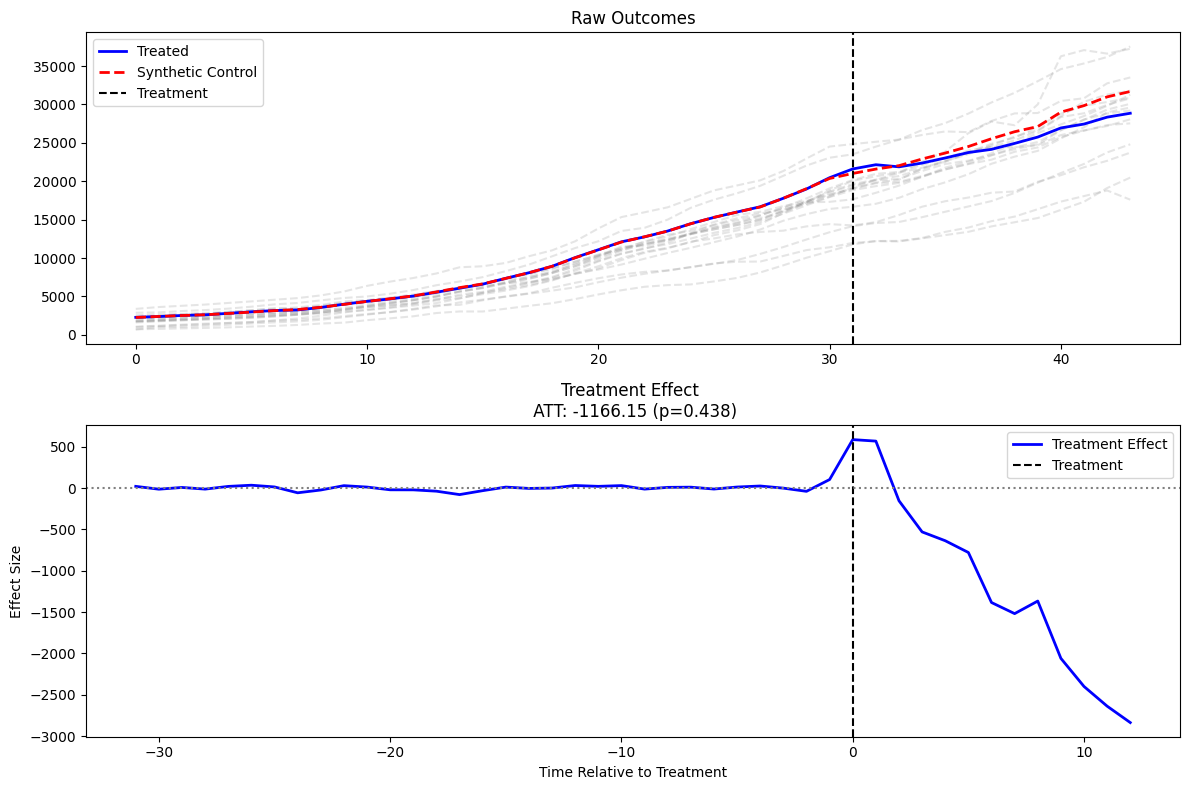

In [31]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Raw outcomes plot
mc_synth2.plot(
    mc_results2, data["Y"], data["treated_units"], data["T_pre"], mode="raw", ax=ax1
)
ax1.set_title("Raw Outcomes")

# Treatment effect plot
mc_synth2.plot(
    mc_results2,
    data["Y"],
    data["treated_units"],
    data["T_pre"],
    mode="effect",
    ax=ax2,
    show_ci=True,
)

plt.tight_layout()
plt.show()

In [32]:
# Fit multiple synthetic controls
synth_methods = [
    Synth(method="lp_norm", p=1.0),
    Synth(method="lp_norm", p=2.0),
    Synth(method="linear"),
    Synth(method="simplex"),
    Synth(method="matrix_completion"),
    Synth(method="matrix_completion", unit_intercept=True, time_intercept=True),
]

results = [
    method.fit(
        data["Y"],
        data["treated_units"],
        data["T_pre"],
        compute_jackknife=False,
        verbose=False,
    )
    for method in synth_methods
]

Choosing regularization parameter using sequential cross-validation
Choosing regularization parameter using sequential cross-validation


In [33]:
from synthlearners.plotting import SynthPlotter

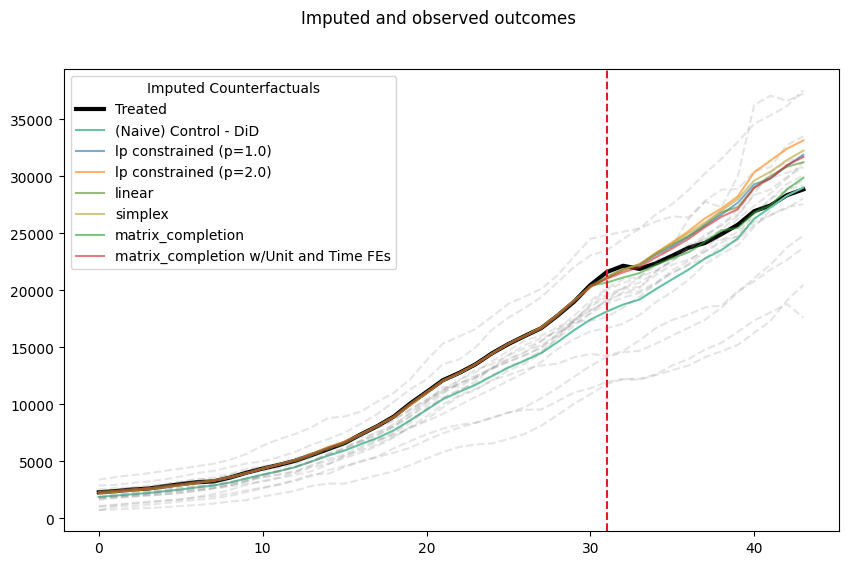

In [34]:
# Create plot
plotter = SynthPlotter()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_trajectories(
    results, data["Y"], data["treated_units"], data["T_pre"], ax=ax, show_controls=True
)
fig.suptitle("Imputed and observed outcomes")
plt.show()

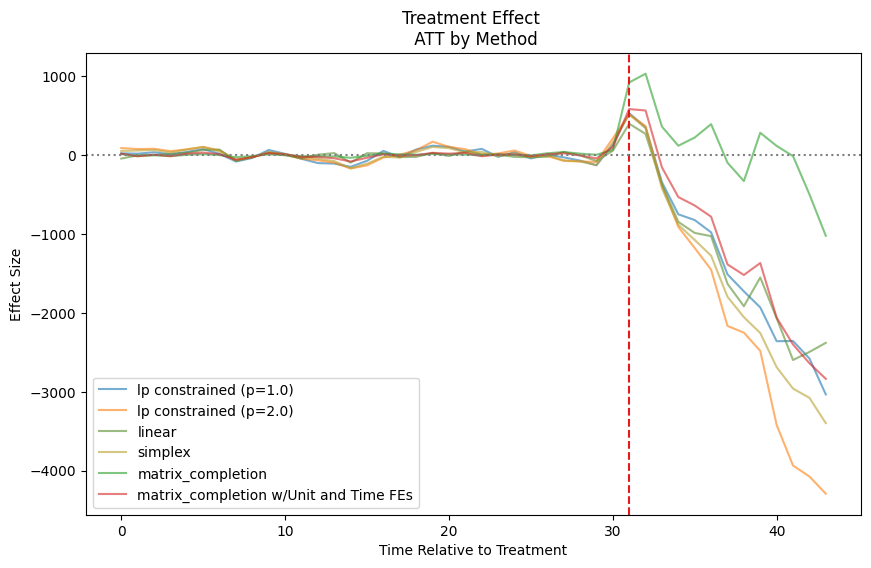

In [35]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter.plot_treatment_effects(results, data["T_pre"], ax=ax)
plt.show()

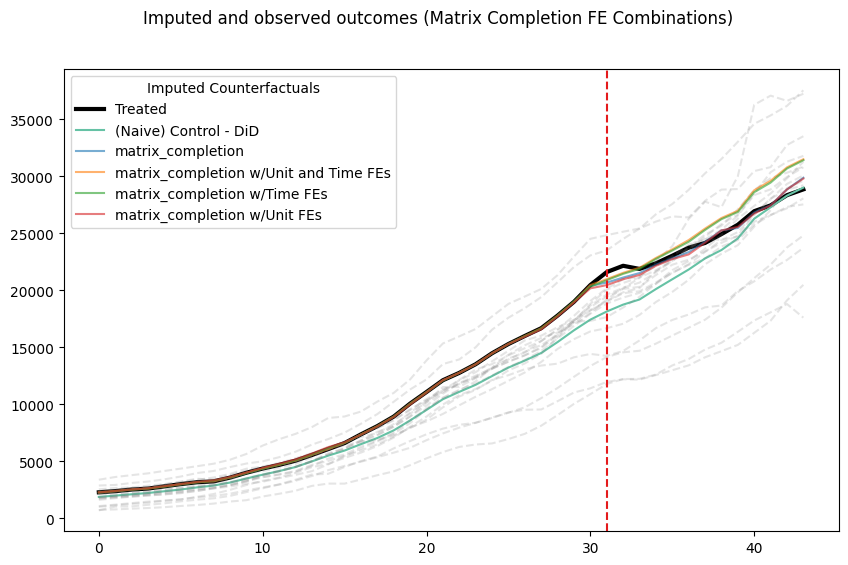

In [36]:
# Fit multiple synthetic controls
synth_methods2 = [
    Synth(method="matrix_completion"),
    Synth(method="matrix_completion", unit_intercept=True, time_intercept=True),
    Synth(method="matrix_completion", unit_intercept=False, time_intercept=True),
    Synth(method="matrix_completion", unit_intercept=True, time_intercept=False),
]

results2 = [
    method.fit(
        data["Y"],
        data["treated_units"],
        data["T_pre"],
        compute_jackknife=False,
        verbose=False,
    )
    for method in synth_methods2
]

# Create plot
plotter2 = SynthPlotter()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter2.plot_trajectories(
    results2, data["Y"], data["treated_units"], data["T_pre"], ax=ax, show_controls=True
)
fig.suptitle("Imputed and observed outcomes (Matrix Completion FE Combinations)")
plt.show()

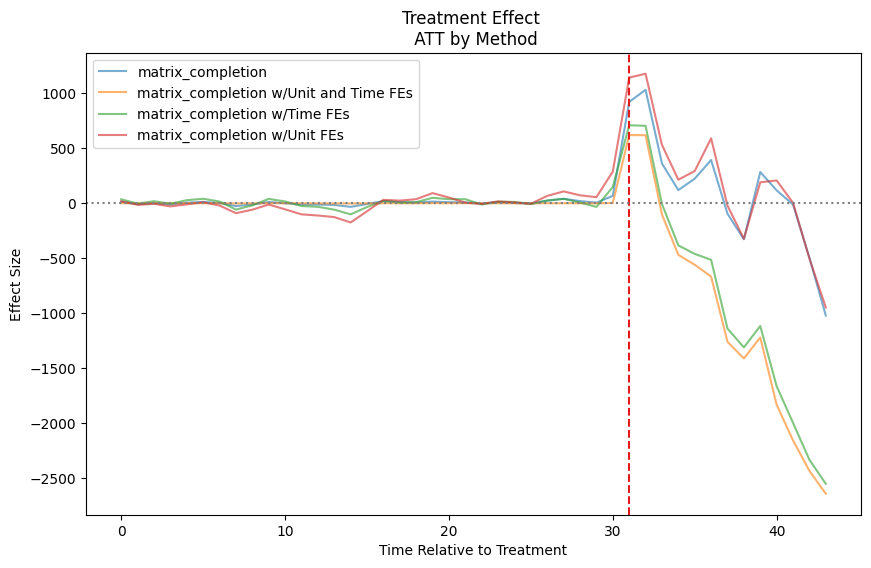

In [37]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plotter2.plot_treatment_effects(results2, data["T_pre"], ax=ax)
plt.show()

# NOTES:
- ADH: N = 17, T = 44
- MC w/Unit FE is similar to MC w/ NO FE
- MC w/Unit and Time FE is similar to MC w/Time FE
- MC w/Unit and Time FE more simliar to other Synthetic Control methods
- Likely makes sense given T > N

In [38]:

from synthlearners.crossvalidation import PanelCrossValidator, cross_validate

In [60]:
"""Test that horizontal splits have the correct shape and properties."""
cv = PanelCrossValidator(n_splits=5)
X = np.random.randn(10, 20)  # 10 units, 20 time periods
    
masks = cv.vertical_split(X)
    
# Check we get correct number of folds
print("len :",len(masks)) # == 5
    
for train_mask, test_mask in masks:
    # Check mask shapes all equal
    print("train_mask shape:", train_mask.shape)
    print(train_mask)
    print("test_mask shape:", test_mask.shape)
    print("X shape:", X.shape)

    # Check masks are mutually exclusive
    assert not np.any(train_mask & test_mask)
        
    # Check that splits are along rows (units)
    train_column_sums = train_mask.sum(axis=0)
    test_column_sums = test_mask.sum(axis=0)
    
    print(np.all((train_column_sums == 0) | (train_column_sums == X.shape[0])))
    print(np.all((test_column_sums == 0) | (test_column_sums == X.shape[0])))
        
    assert np.all((train_column_sums == 0) | (train_column_sums == X.shape[0]))
    assert np.all((test_column_sums == 0) | (test_column_sums == X.shape[0]))

len : 4
train_mask shape: (10, 20)
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  T